In [1]:
%load_ext autoreload
%autoreload 2

# Experiment Pipeline

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision.transforms as TV

from pathlib import Path
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

from hubmap.dataset import TrainDataset, ValDataset
from hubmap.data import DATA_DIR
from checkpoints import CHECKPOINT_DIR

from hubmap.dataset import transforms as T
from hubmap.losses import BCEDiceLoss
from hubmap.losses import MultiOutputBCELoss
from hubmap.losses import ClassWeightedBCELoss
from hubmap.metrics import IoU
from hubmap.training import train
from hubmap.training import LRScheduler
from hubmap.training import EarlyStopping

from hubmap.metrics import model_size

import matplotlib.pyplot as plt

First we load the data that we need for the experiment. This includes the training data, the validation (test) data that we will use for training.

For this, depending on the experiments we use different transformations on the data. The following transformations are a minimal example. Furhter transformations should be included for more sophisticated experiments.

In [3]:
IMG_DIM = 224
NUM_EPOCHS = 100
BATCH_SIZE = 2

Calculate the `mean` and `std` of the `train` dataset.

In [4]:
if os.path.exists(DATA_DIR / "train_dataset_mean.pt") and os.path.exists(
    DATA_DIR / "train_dataset_std.pt"
):
    train_mean = torch.load(DATA_DIR / "train_dataset_mean.pt")
    train_std = torch.load(DATA_DIR / "train_dataset_std.pt")
else:
    train_calc = TrainDataset(DATA_DIR, transform=T.ToTensor())
    data = [train_calc[i] for i in range(len(train_calc))]
    images = list(zip(*data))[0]
    images = torch.stack(images)
    train_mean = torch.mean(images, dim=(0, 2, 3))
    train_std = torch.std(images, dim=(0, 2, 3))
    torch.save(train_mean, DATA_DIR / "train_dataset_mean.pt")
    torch.save(train_std, DATA_DIR / "train_dataset_std.pt")

In [5]:
train_mean, train_std

(tensor([0.6295, 0.4120, 0.6831]), tensor([0.1538, 0.2164, 0.1342]))

In [6]:
if os.path.exists(DATA_DIR / "class_weights.pt"):
    weights = torch.load(Path(DATA_DIR / "class_weights.pt"))
else:
    # calcualte_class_imbalance
    train_calc = TrainDataset(DATA_DIR, transform=T.ToTensor(), with_background=True)
    targets = [train_calc[i][1] for i in range(len(train_calc))]
    # targets = list(zip(*data))[1]
    targets = torch.stack(targets)
    class_sums = torch.sum(targets, dim=(-2, -1))
    total_per_class = torch.sum(class_sums, dim=0)
    total = torch.sum(total_per_class)
    weights = 1 - (total_per_class / total)
    torch.save(weights, Path(DATA_DIR / "class_weights.pt"))

In [7]:
train_transformations = T.Compose(
    [
        T.ToTensor(mask_as_integer=True),
        T.Grayscale(),
        T.Resize((IMG_DIM, IMG_DIM)),
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
        # T.RandomRotation(360),
        T.Normalize([0.5], [0.5]),
    ]
)

val_transformations = T.Compose(
    [
        T.ToTensor(mask_as_integer=True),
        T.Grayscale(),
        T.Resize((IMG_DIM, IMG_DIM)),
        # T.Normalize(train_mean, train_std),
        T.Normalize([0.5], [0.5]),
    ]
)

Depending on the experiment we may want to load all annotated images or just the ones that are annotated by experts.

Here we create a function to load all the images that are annotated (not only the ones by experts).
The created function can than be used to load the data loaders with a specific batch size.

In [8]:
train_dataset = TrainDataset(
    DATA_DIR, transform=train_transformations, with_background=True, as_id_mask=True
)
val_dataset = ValDataset(
    DATA_DIR, transform=val_transformations, with_background=True, as_id_mask=True
)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

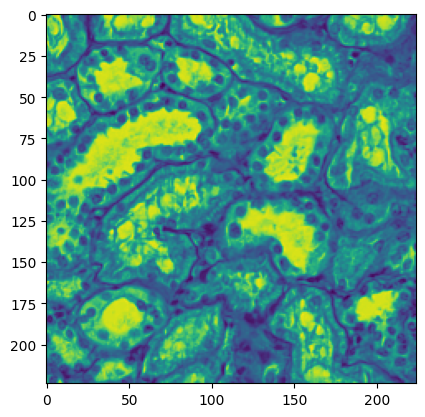

In [10]:
image, target = next(iter(train_loader))
plt.imshow(image[0].permute(1, 2, 0))

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [12]:
@torch.no_grad()
def init_weights(m):
    """
    Initialize the weights
    """
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

In [15]:
from hubmap.models.fct_alternative.model import FCT

model = FCT(img_size=IMG_DIM)
model = model.apply(init_weights)
model = model.to(device)

AssertionError: embed_dim must be divisible by num_heads

In [ ]:
from torchinfo import summary

summary(model, input_size=(BATCH_SIZE, 1, IMG_SIZE, IMG_SIZE))

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# benchmark = IoU()
criterion0 = nn.CrossEntropyLoss(weight=weights.to(device))
criterion1 = nn.CrossEntropyLoss(weight=weights.to(device))
criterion2 = nn.CrossEntropyLoss(weight=weights.to(device))
learning_rate_scheduler = LRScheduler(optimizer, patience=5, min_lr=1e-6, factor=0.8)
early_stopping = None

In [ ]:
checkpoint_name = "fct_alt_224_grayscale.pt"

In [ ]:
continue_training = False

In [ ]:
start_epoch = 1

training_loss_history = []
training_metric_history = []

validation_loss_history = []
validation_metric_history = []

if continue_training:
    # Load checkpoint.
    print("Loading checkpoint...")
    checkpoint = torch.load(Path(CHECKPOINT_DIR / checkpoint_name))
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    training_loss_history = checkpoint["training_loss_history"]
    training_metric_history = checkpoint["training_metric_history"]
    validation_loss_history = checkpoint["validation_loss_history"]
    validation_metric_history = checkpoint["validation_metric_history"]

for epoch in tqdm(range(start_epoch, start_epoch + NUM_EPOCHS)):
    # tqdm.write(f"Epoch {epoch}/{num_epochs} - Started training...")
    training_losses = []
    training_accuracies = []
    model.train()
    for images, targets in tqdm(train_loader):
        images = images.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        predictions = model(images)

        t1 = (
            F.interpolate(targets, size=predictions[0].size()[2:], mode="nearest")
            .squeeze(1)
            .type(torch.LongTensor)
            .to(device)
        )
        t2 = (
            F.interpolate(targets, size=predictions[1].size()[2:], mode="nearest")
            .squeeze(1)
            .type(torch.LongTensor)
            .to(device)
        )
        t_final = targets.squeeze(1).type(torch.LongTensor).to(device)

        # preds_for_loss = F.softmax(preds_for_loss, dim=1)
        loss1 = criterion0(predictions[0], t1)
        loss2 = criterion1(predictions[1], t2)
        loss_final = criterion2(predictions[2], t_final)

        loss1.backward(retain_graph=True)
        loss2.backward(retain_graph=True)
        loss_final.backward(retain_graph=True)

        optimizer.step()

        # metric = benchmark(classes_per_channel, targets)
        probs = F.softmax(predictions[2], dim=1)
        # print("probs size: ", probs.size())
        classes = torch.argmax(probs, dim=1, keepdim=True)
        # print("classes size: ", probs.size())

        equals = ((classes == 0) == (targets == 0)).sum()
        total = (targets == 0).numel()
        acc = equals / total
        metric = acc

        loss = loss1 + loss2 + loss_final
        training_losses.append(loss.item())
        training_accuracies.append(metric.item())

    training_loss_history.append(training_losses)
    training_metric_history.append(training_accuracies)

    validation_losses = []
    validation_accuracies = []
    model.eval()
    for images, targets in tqdm(val_loader):
        images = images.to(device)
        targets = targets.to(device)

        with torch.no_grad():
            predictions = model(images)

            t1 = (
                F.interpolate(targets, size=predictions[0].size()[2:], mode="nearest")
                .squeeze(1)
                .type(torch.LongTensor)
                .to(device)
            )
            t2 = (
                F.interpolate(targets, size=predictions[1].size()[2:], mode="nearest")
                .squeeze(1)
                .type(torch.LongTensor)
                .to(device)
            )
            t_final = targets.squeeze(1).type(torch.LongTensor).to(device)

            # preds_for_loss = F.softmax(preds_for_loss, dim=1)
            loss1 = criterion0(predictions[0], t1)
            loss2 = criterion1(predictions[1], t2)
            loss_final = criterion2(predictions[2], t_final)

            loss = loss1 + loss2 + loss_final

            # print(classes.size(), targets.size())
            probs = F.softmax(predictions[2], dim=1)
            # print("probs size: ", probs.size())
            classes = torch.argmax(probs, dim=1, keepdim=True)

            equals = ((classes == 0) == (targets == 0)).sum()
            total = (targets == 0).numel()
            acc = equals / total
            metric = acc

        validation_losses.append(loss.item())
        validation_accuracies.append(metric.item())

    validation_loss_history.append(validation_losses)
    validation_metric_history.append(validation_accuracies)

    print(
        f"Epoch {epoch}/{NUM_EPOCHS} - Summary: "
        f"TL: {np.mean(training_losses):.5f} "
        f"TB: {np.mean(training_accuracies):.5f} "
        f"VL: {np.mean(validation_losses):.5f} "
        f"VB: {np.mean(validation_accuracies):.5f}"
    )

    data_to_save = {
        "early_stopping": False,
        "epoch": epoch,
        # "start_epoch": start_epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "training_loss_history": training_loss_history,
        "training_metric_history": training_metric_history,
        "validation_loss_history": validation_loss_history,
        "validation_metric_history": validation_metric_history,
    }

    # NOW DO THE ADJUSTMENTS USING THE LEARNING RATE SCHEDULER.
    if learning_rate_scheduler:
        learning_rate_scheduler(np.mean(validation_losses))
    # NOW DO THE ADJUSTMENTS USING THE EARLY STOPPING.
    if early_stopping:
        early_stopping(np.mean(validation_losses))
        # MODIFY THE DATA TO SAVE ACCORDING TO THE EARLY STOPPING RESULT.
        data_to_save["early_stopping"] = early_stopping.early_stop

    # SAVE THE DATA.
    torch.save(data_to_save, Path(CHECKPOINT_DIR / checkpoint_name))

    # DO THE EARLY STOPPING IF NECESSARY.
    if early_stopping and early_stopping.early_stop:
        break

result = {
    "epoch": epoch,
    "training": {
        "loss": training_loss_history,
        "metric": training_metric_history,
    },
    "validation": {
        "loss": validation_loss_history,
        "metric": validation_metric_history,
    },
}

Now we can visualize the results.<br>
(*this needs improvements + better and more visualizations for the final paper*)

In [ ]:
from hubmap.visualization import visualize_result

In [ ]:
loss_fig, benchmark_fig = visualize_result(result)